In [1]:
# 1. Import the relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import warnings

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, accuracy_score

warnings.filterwarnings("ignore")

In [2]:
# 2. Data Loading & Overview ---
df = pd.read_csv("C:/Users/DELL/Downloads/Cloud_watch_data.csv")
print(df.shape)
print(df.columns)
print(df.info())
print(df.describe())

(282, 16)
Index(['bytes_in', 'bytes_out', 'creation_time', 'end_time', 'src_ip',
       'src_ip_country_code', 'protocol', 'response.code', 'dst_port',
       'dst_ip', 'rule_names', 'observation_name', 'source.meta',
       'source.name', 'time', 'detection_types'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bytes_in             282 non-null    int64 
 1   bytes_out            282 non-null    int64 
 2   creation_time        282 non-null    object
 3   end_time             282 non-null    object
 4   src_ip               282 non-null    object
 5   src_ip_country_code  282 non-null    object
 6   protocol             282 non-null    object
 7   response.code        282 non-null    int64 
 8   dst_port             282 non-null    int64 
 9   dst_ip               282 non-null    object
 10  rule_names  

In [3]:
# 3. Data Cleaning ---
df = df.drop_duplicates().copy()
df['creation_time'] = pd.to_datetime(df['creation_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['time'] = pd.to_datetime(df['time'])
df['src_ip_country_code'] = df['src_ip_country_code'].str.upper()
# Clean and convert to string if needed
df['dst_port'] = df['dst_port'].astype(str).str.strip()

In [4]:
# Handle missing values
print(df.isnull().sum())
df['bytes_in'].fillna(df['bytes_in'].median(), inplace=True)
df.dropna(subset=['src_ip', 'dst_ip'], inplace=True)

bytes_in               0
bytes_out              0
creation_time          0
end_time               0
src_ip                 0
src_ip_country_code    0
protocol               0
response.code          0
dst_port               0
dst_ip                 0
rule_names             0
observation_name       0
source.meta            0
source.name            0
time                   0
detection_types        0
dtype: int64


In [5]:
#  4. Feature Engineering : Creating new columns by using existing columns
df['duration_seconds'] = (df['end_time'] - df['creation_time']).dt.total_seconds().replace(0, 1)
df['avg_packet_size'] = (df['bytes_in'] + df['bytes_out']) / df['duration_seconds']

In [6]:
# 5. Encoding & Scaling 
numeric_features = ['bytes_in', 'bytes_out', 'duration_seconds', 'avg_packet_size']
categorical_features = ['src_ip_country_code', 'protocol', 'response.code']

In [7]:
scaler = StandardScaler()
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

scaled_df = pd.DataFrame(scaler.fit_transform(df[numeric_features]),
                         columns=[f"scaled_{col}" for col in numeric_features],
                         index=df.index)

encoded_df = pd.DataFrame(encoder.fit_transform(df[categorical_features]),
                          columns=encoder.get_feature_names_out(categorical_features),
                          index=df.index)

transformed_df = pd.concat([df, scaled_df, encoded_df], axis=1)

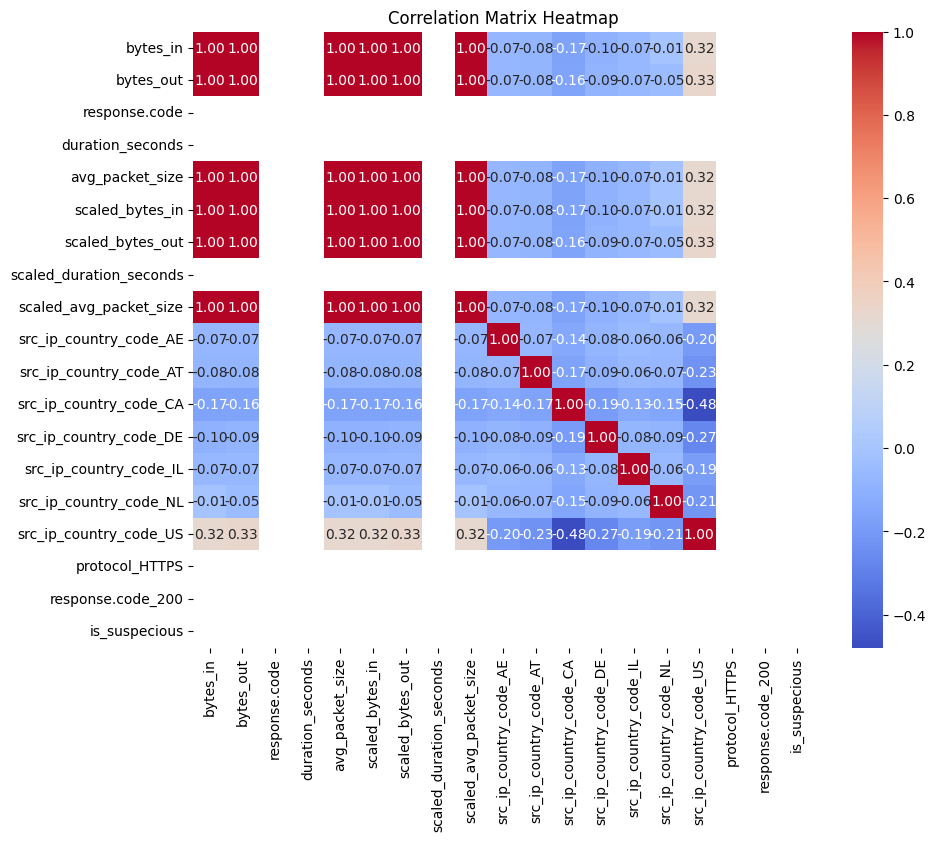

In [38]:
# 6. Exploratory Data Analysis

# Compute the correlation matrix for numeric columns only
numeric_df = transformed_df.select_dtypes(include = ['float64', 'int64'])
correlation_matrix_numeric = numeric_df.corr()

# Heatmap for correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_numeric, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

<Figure size 1400x600 with 0 Axes>

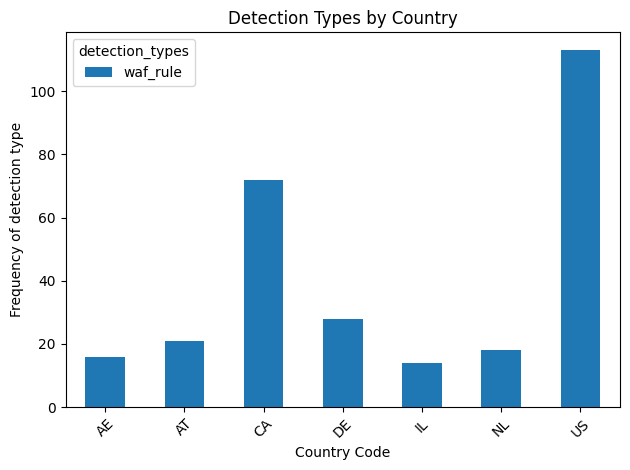

In [36]:
# Detection Types by Country
plt.figure(figsize=(14, 6))
country_counts = pd.crosstab(df['src_ip_country_code'], df['detection_types'])
country_counts.plot(kind='bar', stacked=True)
plt.title("Detection Types by Country")
plt.xlabel("Country Code")
plt.ylabel("Frequency of detection type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

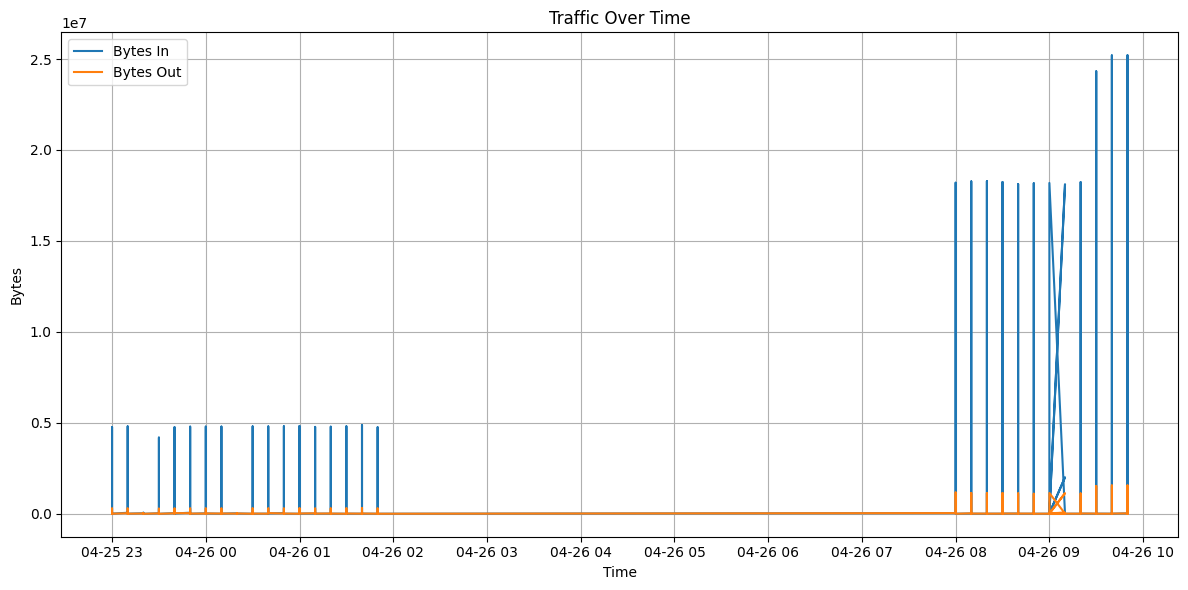

In [10]:
# Traffic Over Time
df.set_index('creation_time', inplace=True)
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['bytes_in'], label='Bytes In')
plt.plot(df.index, df['bytes_out'], label='Bytes Out')
plt.title('Traffic Over Time')
plt.xlabel('Time')
plt.ylabel('Bytes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

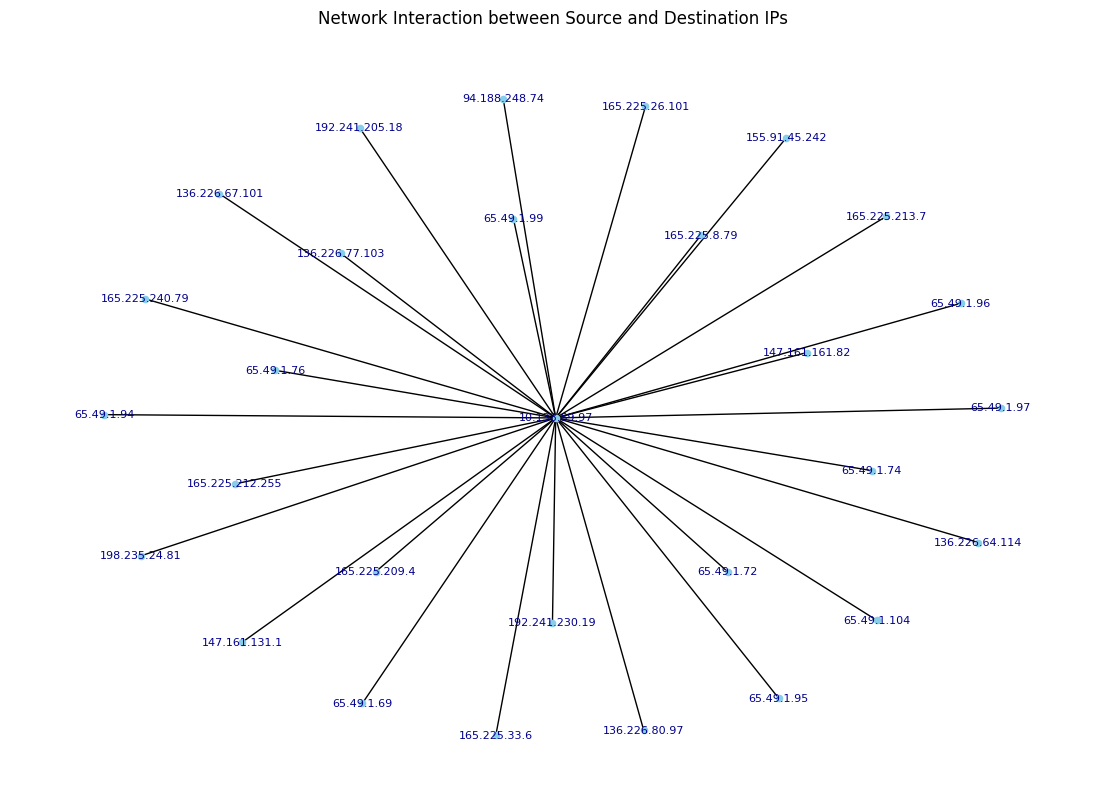

In [31]:
# Draw the network graph
plt.figure(figsize=(14, 10))
nx.draw_networkx(G, with_labels=True, node_size=20,
font_size=8, node_color='skyblue', font_color='darkblue')
plt.title('Network Interaction between Source and Destination IPs')
plt.axis('off') 
plt.show()


In [12]:
# --- 7. Anomaly Detection ---
anomaly_features = ['scaled_bytes_in', 'scaled_bytes_out', 'scaled_duration_seconds', 'scaled_avg_packet_size']
df_anomaly = transformed_df.copy()
iso_model = IsolationForest(contamination=0.05, random_state=42)
df_anomaly['anomaly'] = iso_model.fit_predict(df_anomaly[anomaly_features])
df_anomaly['anomaly'] = df_anomaly['anomaly'].map({-1: 'Anomaly', 1: 'Normal'})

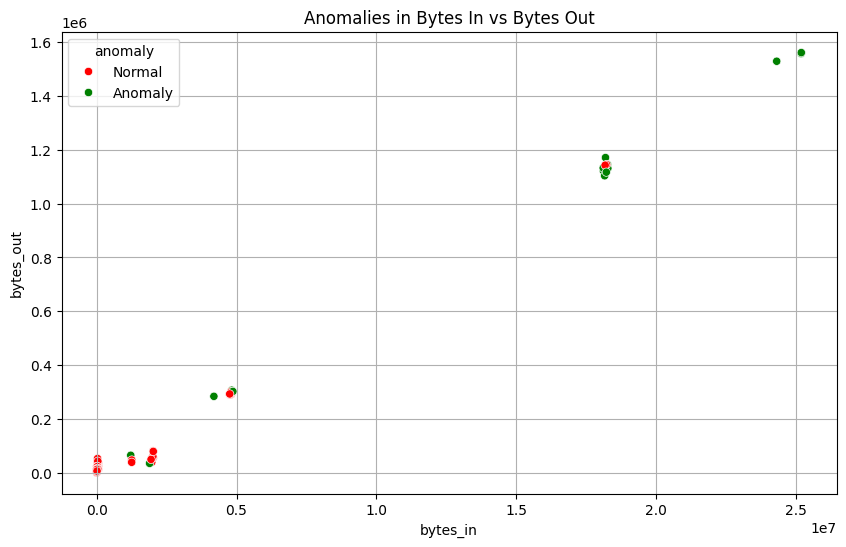

In [13]:
# Anomaly Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x='bytes_in', y='bytes_out', hue='anomaly', data=df_anomaly, palette=['red', 'green'])
plt.title('Anomalies in Bytes In vs Bytes Out')
plt.grid()
plt.show()

In [14]:
# --- 8. Classification Model (Random Forest) ---
transformed_df['is_suspecious'] = (transformed_df['detection_types'] == 'waf_rule').astype(int)
X = transformed_df[anomaly_features]
y = transformed_df['is_suspecious']

In [15]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict using the trained model
y_pred = clf.predict(X_test)


In [16]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 1.0


In [17]:
print("Classification Report",classification_report(y_test, y_pred))

Classification Report               precision    recall  f1-score   support

           1       1.00      1.00      1.00        85

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85



In [18]:
# Cross-validation
scores = cross_val_score(clf, X, y, cv=5)
print("Cross-Validation Accuracy:", scores.mean())

Cross-Validation Accuracy: 1.0


In [19]:
importances = clf.feature_importances_
features = X.columns

# Check for issues
print("Importances:", importances)

# Only plot if importances are non-zero
if np.any(importances):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=importances, y=features)
    plt.title("Random Forest Feature Importance")
    plt.tight_layout()
    plt.show()
else:
    print("Model feature importances are all zero. Investigate training data or target imbalance.")


Importances: [0. 0. 0. 0.]
Model feature importances are all zero. Investigate training data or target imbalance.


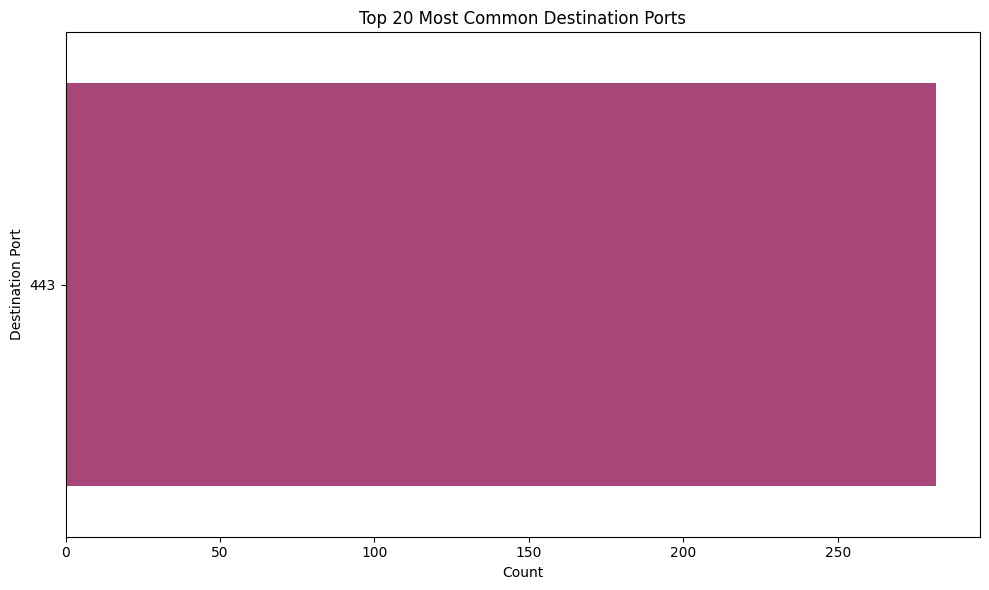

In [28]:
top_ports = df['dst_port'].value_counts().head(20)
plt.figure(figsize=(10, 6))
sns.barplot(y=top_ports.index, x=top_ports.values, palette='magma')
plt.title("Top 20 Most Common Destination Ports")
plt.xlabel("Count")
plt.ylabel("Destination Port")
plt.tight_layout()
plt.show()

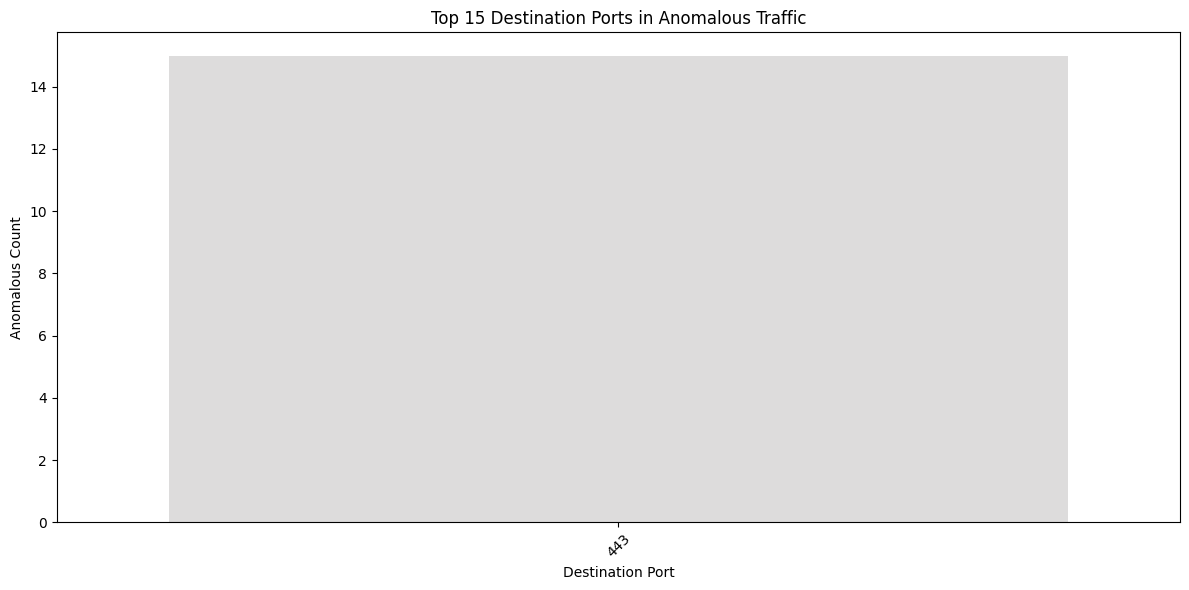

In [29]:
# Suspicious port usage
suspicious_ports = df_anomaly[df_anomaly['anomaly'] == 'Anomaly']['dst_port'].value_counts().head(15)
plt.figure(figsize=(12, 6))
sns.barplot(x=suspicious_ports.index, y=suspicious_ports.values, palette='coolwarm')
plt.title("Top 15 Destination Ports in Anomalous Traffic")
plt.xlabel("Destination Port")
plt.ylabel("Anomalous Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

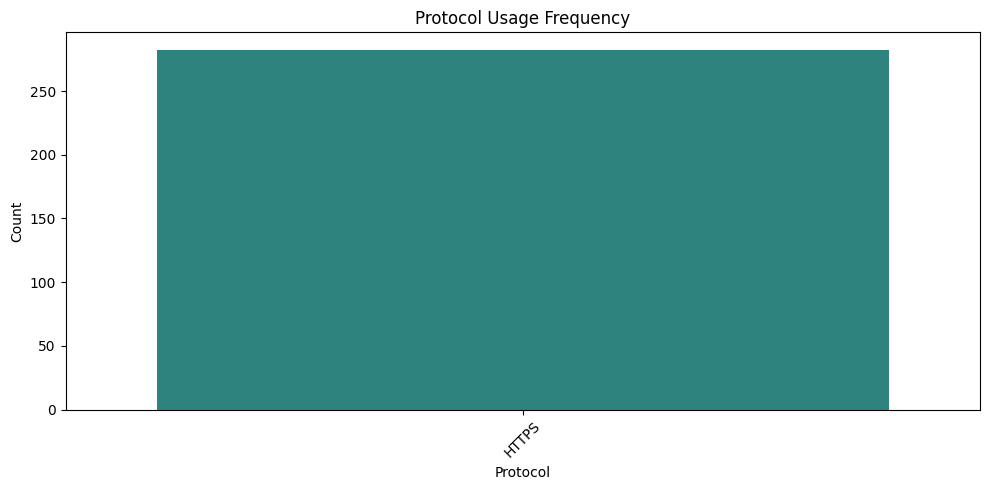

In [22]:
# Protocol distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='protocol', order=df['protocol'].value_counts().index, palette='viridis')
plt.title("Protocol Usage Frequency")
plt.xlabel("Protocol")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


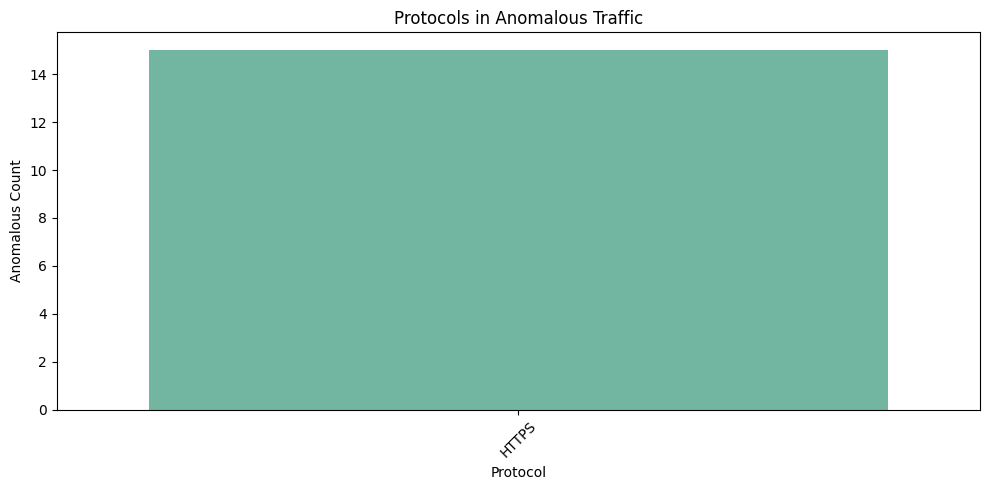

In [30]:
# Anomalous protocols
anomaly_protocols = df_anomaly[df_anomaly['anomaly'] == 'Anomaly']['protocol'].value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x=anomaly_protocols.index, y=anomaly_protocols.values, palette='Set2')
plt.title("Protocols in Anomalous Traffic")
plt.xlabel("Protocol")
plt.ylabel("Anomalous Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

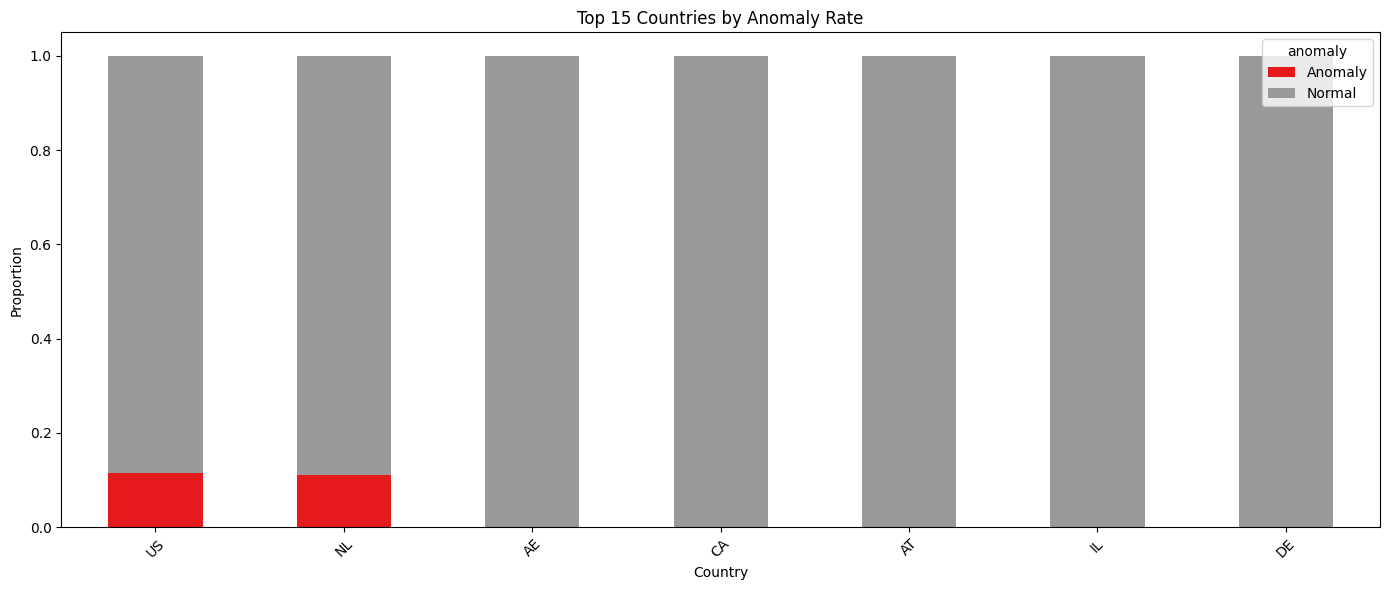

In [24]:
# Anomaly rate per country
country_anomaly_rate = df_anomaly.groupby('src_ip_country_code')['anomaly'].value_counts(normalize=True).unstack().fillna(0)
country_anomaly_rate = country_anomaly_rate.sort_values(by='Anomaly', ascending=False).head(15)

# Plot
country_anomaly_rate[['Anomaly', 'Normal']].plot(kind='bar', stacked=True, figsize=(14, 6), colormap='Set1')
plt.title("Top 15 Countries by Anomaly Rate")
plt.ylabel("Proportion")
plt.xlabel("Country")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


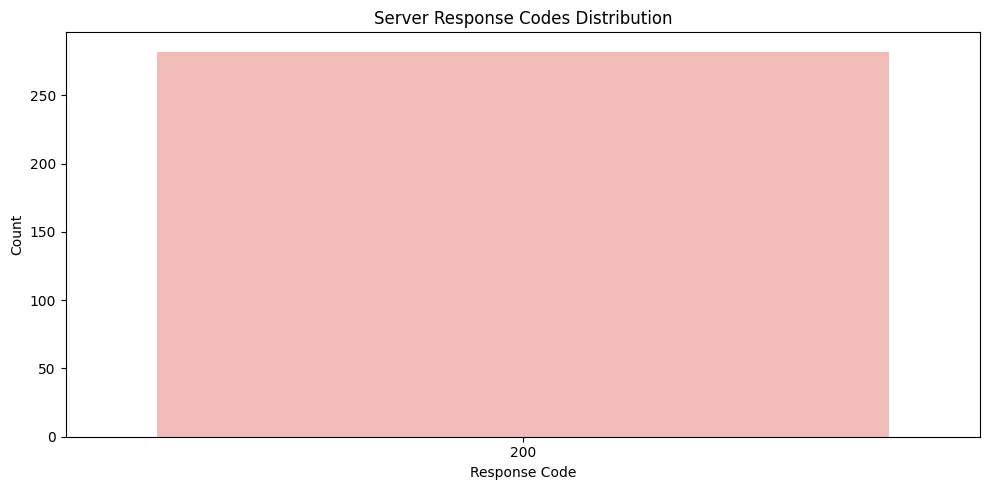

In [25]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='response.code', order=df['response.code'].value_counts().index, palette='Pastel1')
plt.title("Server Response Codes Distribution")
plt.xlabel("Response Code")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

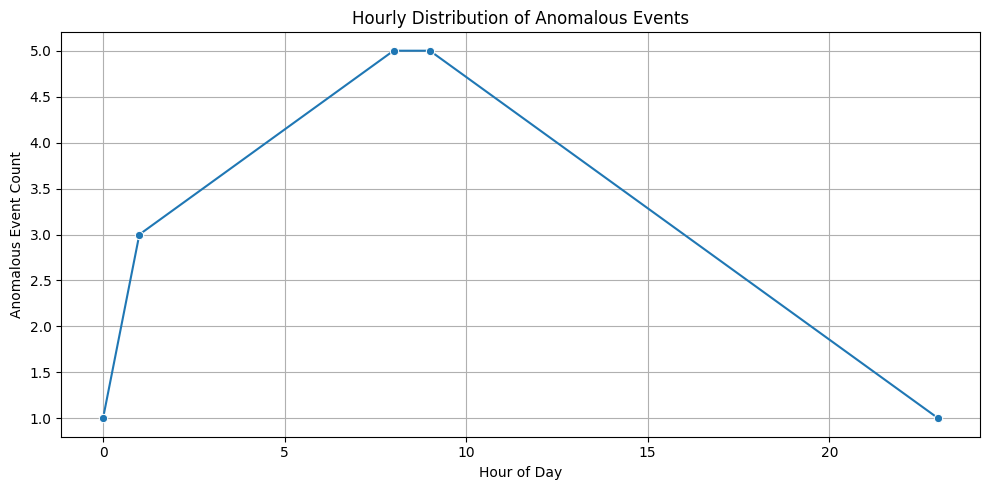

In [26]:
# Extract hour from creation_time column (not index)
df_anomaly['hour'] = df_anomaly['creation_time'].dt.hour

# Hourly anomaly count
hourly_anomalies = df_anomaly[df_anomaly['anomaly'] == 'Anomaly']['hour'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 5))
sns.lineplot(x=hourly_anomalies.index, y=hourly_anomalies.values, marker='o')
plt.title("Hourly Distribution of Anomalous Events")
plt.xlabel("Hour of Day")
plt.ylabel("Anomalous Event Count")
plt.grid(True)
plt.tight_layout()
plt.show()
